Prediciting Future Stock Price of Palantir Using LSTM Neural Network

In [1]:
import yfinance as yf

Data Collection

In [2]:
# Download OHLOV Prive data for PLTR Stock for the past year with an interval of 1 day.
data = yf.download("PLTR", period="1y", interval="1d")
# View last 10 instances
print(data.tail(10))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           PLTR       PLTR       PLTR       PLTR       PLTR
Date                                                             
2025-03-28  85.849998  89.379997  84.099998  89.339996   91091700
2025-03-31  84.400002  84.650002  78.750000  80.000000  108092900
2025-04-01  84.680000  85.279999  81.820000  83.889999   78980700
2025-04-02  87.449997  88.404999  82.300003  82.400002   96563100
2025-04-03  83.599998  85.680000  81.010002  81.250000   93878200
2025-04-04  74.010002  80.980003  71.930000  80.070000  147323200
2025-04-07  77.839996  81.800003  66.120003  66.650002  169083700
2025-04-08  77.320000  86.113998  75.220001  83.290001  135345600
2025-04-09  92.010002  93.330002  77.269997  78.190002  187244300
2025-04-10  88.589996  90.779999  84.139999  88.400002  124091700


Data Visualization

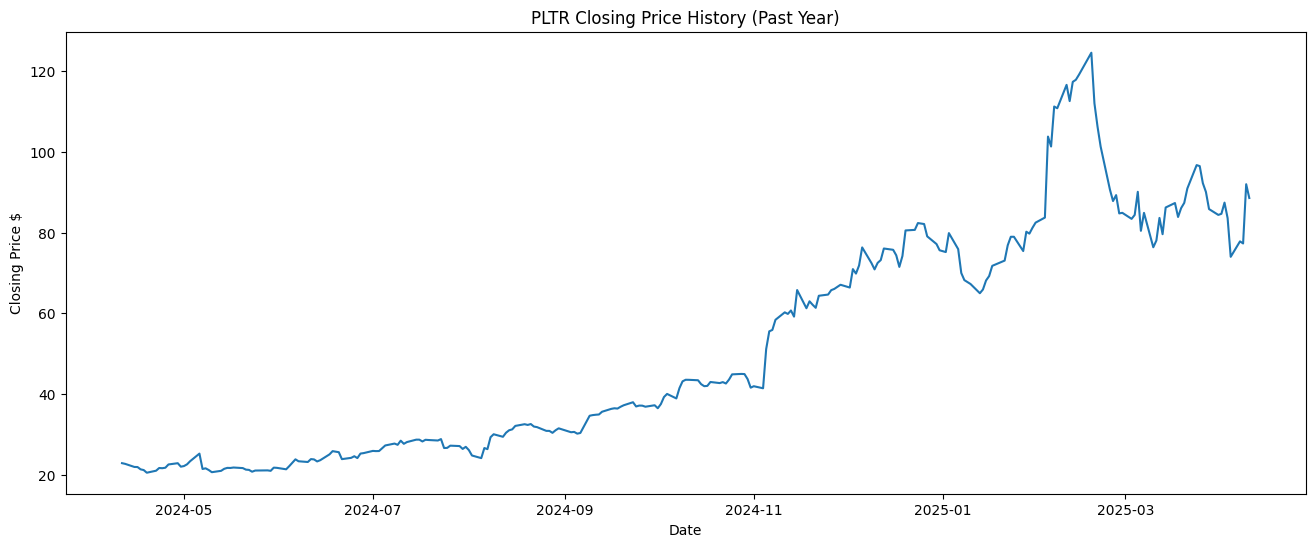

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the closing price of PLTR 
plt.figure(figsize=(16,6))
plt.title("PLTR Closing Price History (Past Year)")
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.show() 

Data Preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Get only the 'Close' column
close = data[['Close']]

# Turn the pandas df to a numpy array
dataset = close.to_numpy()

# Normalize the Data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset)

# Split into training and testing sets
train_size = int(len(scaled_dataset) * 0.70)
train_data = scaled_dataset[:train_size]
test_data = scaled_dataset[train_size:]

def sequence(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0]) # 6o time steps
        y.append(data[i,0])               # the value right after
    
    return np.array(x), np.array(y)

x_train, y_train = sequence(train_data,60)
x_test, y_test = sequence(test_data,60)

# reshape to get 3D Inputs: (samples, time_steps, features)
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)


(115, 60, 1)
(16, 60, 1)
